# PART 1: Loading/preprocessing images and creating additional datasets

In [1]:
## Importing the necessary packages
import numpy as np
import pandas as pd
import seaborn as sns
import os
import cv2
import csv
from skimage import feature
import matplotlib.pyplot as plt
from sklearn import preprocessing
# I use this to print the plots in the notebook
%matplotlib inline
# I use this to give a white background to the images in my dark theme notebook
#from matplotlib import style
#style.use('dark_background')
#sns.set(style="whitegrid")

C:\Anaconda\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


I downloaded the dataset from [here](https://github.com/chandrikadeb7/Face-Mask-Detection), removing some instances manually to have a total of 1600 images of faces without a mask and 600 images of people with mask.

With the following code it is possible to load the dataset, resize/binarise the images, and then create an additional image repository using Histogram of Gradients (HOG).


Loading images...
Invalid file desktop.ini skipped.

Calculating class distribution...
          Class  Number of Samples
0     with_mask                600
1  without_mask               1600
Total images: 2200

Showing class distribution bar chart...


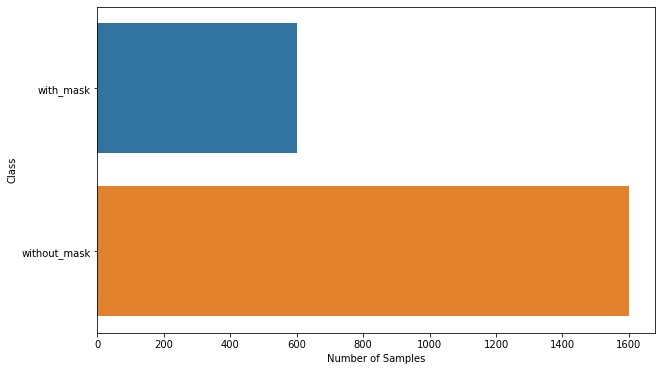

Size of target:  2200
Size of original repository:  (2200, 10000)
Example of the original repository: 
[[242 241 241 ...  38  41  43]
 [212 189 161 ... 128 127 127]
 [ 18  23  20 ... 233 233 235]
 ...
 [ 26  27  28 ...  69  67  66]
 [ 32  32  34 ... 149 155 156]
 [166 148 117 ...  42  45  47]]
Size of binarised data structure:  (2200, 10000)
Example of the binarised repository: 
[[255 255 255 ...   0   0   0]
 [255 255   0 ...   0   0   0]
 [  0   0   0 ... 255 255 255]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]
Size of HOG features data structure:  (2200, 1800)
Example of the HOG repository: 
[[0.02900035 0.02449609 0.02765162 ... 0.03078451 0.04618735 0.012421  ]
 [0.11356097 0.0079037  0.00372234 ... 0.01835677 0.00335064 0.        ]
 [0.08076974 0.01799404 0.04536206 ... 0.00797704 0.00512518 0.00419422]
 ...
 [0.1527991  0.02251848 0.02054662 ... 0.00469979 0.         0.        ]
 [0.12178626 0.11175205 0.18777976 ... 0.00934

In [2]:
# Ignore warnings
import warnings; warnings.simplefilter('ignore')
################################ 1. DEFINE CLASS TO EXTRACT HOG FEATURES ################################    
class HOG:
    def __init__(self, orientations = 9, pixelsPerCell = (8, 8),
        cellsPerBlock = (3, 3), transform = False):
        # store the number of orientations, pixels per cell,
        # cells per block, and whether or not power law
        # compression should be applied
        self.orienations = orientations
        self.pixelsPerCell = pixelsPerCell
        self.cellsPerBlock = cellsPerBlock
        self.transform = transform

    def describe(self, image):
        # compute HOG for the image
        hist = feature.hog(image, orientations = self.orienations,
            pixels_per_cell = self.pixelsPerCell,
            cells_per_block = self.cellsPerBlock,
            transform_sqrt = self.transform)
        ## return the HOG features
        return hist
    
hog = HOG(orientations = 18, pixelsPerCell = (10, 10), cellsPerBlock = (1, 1), transform = True)

########  2. LOAD IMAGES (FOR ORIGINAL REPO), BINARISE (FOR PREPROCESSED REPO) & EXTRACT HOG FEATURES (FOR FEATURE REPO) ######## 

bin_thresh = 180 # Threshold for binarisation
resize_factor = 100 # applies for both height and width

path = 'data'
datarepo = [] # List to append the images as 2D numpy arrays
originalrepo = [] # Create a repo for flattened pixels
binarisedrepo = []  # Create a list to append the binarised pixels
hogrepo = [] # Create a list to append the HOG features
target = [] # List to append the target/class/label
print('\nLoading images...')
for root, dirs, files in os.walk(path):
     for file in files:
        with open(os.path.join(root, file), "r") as auto:
            try:
                img = cv2.imread(root+'/'+file, 0)
                img = cv2.resize(img, (resize_factor, resize_factor)) 
                datarepo.append(img)
                originalrepo.append(img.flatten())
                _, img_bin = cv2.threshold(img, bin_thresh, 255, 0) 
                # Append the flattened image to the pixel repo
                binarisedrepo.append(img_bin.flatten())
                # Extract HOG and append to HOG repo
                hogfeatures = hog.describe(img)
                hogrepo.append(hogfeatures)
                # Append the folder where the image is to the target list
                target.append(root.replace(path,'').replace('\\',''))
            except Exception as e:
                print("Invalid file "+file+" skipped.")
            
# Convert the repo lists into numpy arrays
originalrepo = np.array(originalrepo)
binarisedrepo = np.array(binarisedrepo)
hogrepo = np.array(hogrepo)

########################## 3. CALCULATE THE DISTRIBUTION AND SHOW REPOS ##########################

print('\nCalculating class distribution...')
histo = [['Class','Number of Samples']]
for i, label1 in enumerate(sorted(list(set(target)))):
    cont = 0
    for j, label2 in enumerate(target):
        if label1 == label2:
            cont+=1
    histo.append([label1,cont])
histo.append(['Total Samples', len(target)])
## Save the histogram as a .csv file   
with open('classdistribution.csv', 'w', newline='', encoding='utf-8') as csvfile:
    filewriter = csv.writer(csvfile, delimiter=',')
    for i, hist in enumerate(histo):
        filewriter.writerow(hist)
## Load as a panda
histo_panda = pd.DataFrame.from_records(histo[1:-1], columns=histo[0])
print(histo_panda)
print('Total images: '+str(len(target)))
## Create a histogram using seaborn
sns_plot = sns.barplot(y="Class", x="Number of Samples", data=histo_panda)
## Save the image
sns_plot.figure.set_size_inches(10,6)
sns_plot.figure.savefig('barchart.jpg', orientation = 'landscape', dpi = 600, transparent=True)
print('\nShowing class distribution bar chart...')
plt.show()
print('Size of target: ', len(target))
print('Size of original repository: ', originalrepo.shape)
print('Example of the original repository: ')
print(originalrepo)
print('Size of binarised data structure: ', binarisedrepo.shape)
print('Example of the binarised repository: ')
print(binarisedrepo)
print('Size of HOG features data structure: ', hogrepo.shape)
print('Example of the HOG repository: ')
print(hogrepo)

################################ 4. SAVE THE DATASETS AS CSV FILES ################################

print('\nSaving datasets as .csv files...')   

with open('original.csv', 'w', newline='', encoding='utf-8') as csvfile:
    filewriter = csv.writer(csvfile, delimiter=',')
    for i, pix in enumerate(originalrepo):
        row = np.concatenate((pix,[target[i]]))
        filewriter.writerow(row)

with open('hog.csv', 'w', newline='', encoding='utf-8') as csvfile:
    filewriter = csv.writer(csvfile, delimiter=',')
    for i, h in enumerate(hogrepo):
        row = np.concatenate((h,[target[i]]))
        filewriter.writerow(row)

with open('binarised.csv', 'w', newline='', encoding='utf-8') as csvfile:
    filewriter = csv.writer(csvfile, delimiter=',')
    for i, l in enumerate(binarisedrepo):
        row = np.concatenate((l,[target[i]]))
        filewriter.writerow(row)

print('\nData saved into .csv files!')  

In the next cell, I implemented Random OverSampling (ROS, more info about this algorithm [here](https://imbalanced-learn.readthedocs.io/en/stable/over_sampling.html)) to perform augmentation of the HOG dataset to balance the classes to 1600 each. This new dataset has 3200 samples in total.


Calculating class distribution (after ROS)...
          Class  Number of Samples
0     with_mask               1600
1  without_mask               1600
Total images: 3200

Showing class distribution bar chart (after ros)...


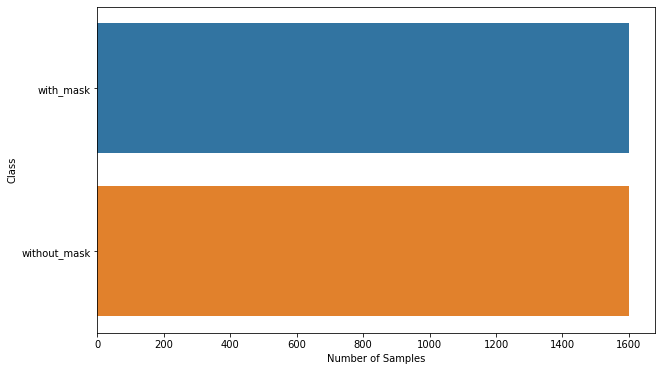

Size of ROS augmented target:  3200
Size of ROS augmented repository:  (3200, 1800)
Example of the ROS augmented repository: 
[[0.02900035 0.02449609 0.02765162 ... 0.03078451 0.04618735 0.012421  ]
 [0.11356097 0.0079037  0.00372234 ... 0.01835677 0.00335064 0.        ]
 [0.08076974 0.01799404 0.04536206 ... 0.00797704 0.00512518 0.00419422]
 ...
 [0.07712584 0.         0.00798625 ... 0.0708078  0.02744511 0.01469945]
 [0.24304768 0.05080687 0.01622416 ... 0.01344316 0.01201563 0.00358632]
 [0.05818418 0.01897425 0.04017461 ... 0.0632027  0.01673798 0.04224042]]

Saving dataset as .csv file...

Data saved!


In [3]:
########################## 1. CALCULATE NEW DATASET USING RANDOM OVERSAMPLING (ROS) ##########################

from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
hogrepo_ros, target_ros = ros.fit_resample(hogrepo,target)

################################ 2. CALCULATE THE DISTRIBUTION AFTER ROS ################################

print('\nCalculating class distribution (after ROS)...')
histo = [['Class','Number of Samples']]
for i, label1 in enumerate(sorted(list(set(target_ros)))):
    cont = 0
    for j, label2 in enumerate(target_ros):
        if label1 == label2:
            cont+=1
    histo.append([label1,cont])
histo.append(['Total Samples', len(target_ros)])
## Save the histogram as a .csv file   
with open('classdistribution_ros.csv', 'w', newline='', encoding='utf-8') as csvfile:
    filewriter = csv.writer(csvfile, delimiter=',')
    for i, hist in enumerate(histo):
        filewriter.writerow(hist)
## Convert histo into a panda dataframe
histo_panda = pd.DataFrame.from_records(histo[1:-1], columns=histo[0])
print(histo_panda)
print('Total images: '+str(len(target_ros)))
## Create a histogram using seaborn
sns_plot = sns.barplot(y="Class", x="Number of Samples", data=histo_panda)
## Save the image
sns_plot.figure.set_size_inches(10,6)
sns_plot.figure.savefig('barchart_ros.jpg', orientation = 'landscape', dpi = 600, transparent=True)
print('\nShowing class distribution bar chart (after ros)...')
plt.show()

print('Size of ROS augmented target: ', len(target_ros))
print('Size of ROS augmented repository: ', hogrepo_ros.shape)
print('Example of the ROS augmented repository: ')
print(hogrepo_ros)

################################ 3. SAVE THE ROS DATASET AS CSV FILE ################################

print('\nSaving dataset as .csv file...')   

with open('hog_ros.csv', 'w', newline='', encoding='utf-8') as csvfile:
    filewriter = csv.writer(csvfile, delimiter=',')
    for i, h in enumerate(hogrepo_ros):
        row = np.concatenate((h,[target_ros[i]]))
        filewriter.writerow(row)
        
print('\nData saved!')  

Finally, the following cell performs the classical class decomposition with *kmeans* to create a pixel repository with the decomposed classes. The size of the final repository remains at 2200 samples but now it has 3 classes in total.


Calculating k values...
Values of k for each class:  [1, 2]
Number of classes after class decomposition:  3

Class decomposition by applying k-means...
Number of clusters for class with_mask: 1
Number of clusters for class without_mask: 2

Calculating class distribution (after class decomposition)...
             Class  Number of Samples
0     with_mask_c0                600
1  without_mask_c0                799
2  without_mask_c1                801
Total images: 2200

Showing class distribution bar chart (after cd)...


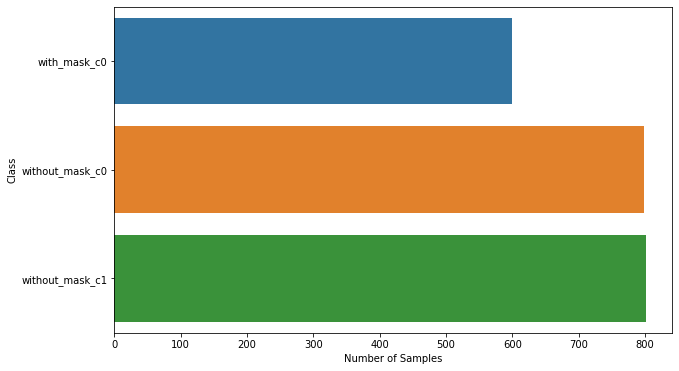


Saving dataset as .csv file...

Data saved!


In [4]:
################################ 1. CALCULATE K USING STANDARD BALANCING EQ ################################

def standardbalancingequation(target):
    '''This function follows the standard balancing equation to calculate k for each class'''
    import math
    print('\nCalculating k values...')
    ## Obtain the number of classes in label list and sort
    labelsIndexesUnique = list(set(target))
    labelsIndexesUnique.sort()
    ## For each class, count the number of instances and calculate ki
    k = []
    for label in labelsIndexesUnique:
        k.append(target.count(label))
    avgInst = sum(k)/len(k)
    k = [math.floor((ki/avgInst)+1) for ki in k]
    print('Values of k for each class: ', k)
    return k

k_kmeans = standardbalancingequation(target)
print('Number of classes after class decomposition: ', sum(k_kmeans))

################################ 2. CLASS DECOMPOSITION USING KMEANS ################################

def CDKmeans(data, target, k):
    print('\nClass decomposition by applying k-means...')    
    from sklearn.cluster import KMeans
    target_cd = ['']*len(target)
    IndexesUnique = list(set(target))
    IndexesUnique.sort()
    for i, label in enumerate(IndexesUnique):
        print('Number of clusters for class '+str(label)+': '+str(k[i]))
        ## Split the dataset
        data_tocluster = []
        data_tocluster_index = []
        for j, dat in enumerate(data):
            if target[j]==label:
                data_tocluster.append(dat)
                data_tocluster_index.append(j)
        if 1<k[i]<=len(data_tocluster):
                ## Apply k-means to the list    
                kmeans = KMeans(n_clusters=k[i], random_state=0).fit(data_tocluster)
                for n, m in enumerate(kmeans.labels_):
                    target_cd[data_tocluster_index[n]]=str(label)+'_c'+str(m)
        else:
            for m in data_tocluster_index:
                target_cd[m]=str(label)+'_c0'
    return target_cd

target_cd = CDKmeans(originalrepo, target, k_kmeans)

################################ 3. CALCULATE THE DISTRIBUTION AFTER CD ################################

print('\nCalculating class distribution (after class decomposition)...')
histo = [['Class','Number of Samples']]
for i, label1 in enumerate(sorted(list(set(target_cd)))):
    cont = 0
    for j, label2 in enumerate(target_cd):
        if label1 == label2:
            cont+=1
    histo.append([label1,cont])
histo.append(['Total Samples', len(target_cd)])
## Save the histogram as a .csv file   
with open('classdistribution_cd.csv', 'w', newline='', encoding='utf-8') as csvfile:
    filewriter = csv.writer(csvfile, delimiter=',')
    for i, hist in enumerate(histo):
        filewriter.writerow(hist)
## Convert histo into a panda dataframe
histo_panda = pd.DataFrame.from_records(histo[1:-1], columns=histo[0])
print(histo_panda)
print('Total images: '+str(len(target_cd)))
## Create a histogram using seaborn
sns_plot = sns.barplot(y="Class", x="Number of Samples", data=histo_panda)
## Save the image
sns_plot.figure.set_size_inches(10,6)
sns_plot.figure.savefig('barchart_cd.jpg', orientation = 'landscape', dpi = 600, transparent=True)
print('\nShowing class distribution bar chart (after cd)...')
plt.show()

################################ 4. SAVE THE CD DATASET AS CSV FILE ################################

print('\nSaving dataset as .csv file...')   

with open('original_cd.csv', 'w', newline='', encoding='utf-8') as csvfile:
    filewriter = csv.writer(csvfile, delimiter=',')
    for i, pix in enumerate(originalrepo):
        row = np.concatenate((pix,[target_cd[i]]))
        filewriter.writerow(row)
        
print('\nData saved!')

After this, classification can be applied!